In [1]:
import importlib
import read_data
import pandas as pd

# =============================
# Load Prior data with emobase features 
# =============================

In [ ]:
# Reload custom functions to reflect changes during runtime
importlib.reload(read_data)
# Load preprocessed Prior (Fred) dataset with emobase features
data = read_data.read_fred_emobase()
data.head()

In [3]:
import Print_data
importlib.reload(Print_data)
print('All data')
Print_data.printdata(data)


All data
Total Size: 81, Subject Size: 81
HC - Sample Size: 41, Subject Size: 41
PD - Sample Size: 40, Subject Size: 40
HC Female - Sample Size: 25, Subject Size: 25
HC Male - Sample Size: 16, Subject Size: 16
PD Female - Sample Size: 19, Subject Size: 19
PD Male - Sample Size: 21, Subject Size: 21


In [ ]:
import Group_age_gender
importlib.reload(Group_age_gender)
# Split data into two age groups: Mid (<55), Old (>55)
data_mid, data_old = Group_age_gender.age2(data, 55)

In [6]:
import Train_Test
importlib.reload(Train_Test)
# Perform train-test split for each age group
print('Mid')
data_train_mid, data_test_mid = Train_Test.split_and_print2(data_mid)

print('Old')
data_train_old, data_test_old = Train_Test.split_and_print2(data_old)

Mid
  Set Condition Gender  Sample Size  Subject Size
Train        HC Female           14            14
Train        HC   Male            7             7
Train        PD Female            1             1
Train        PD   Male            1             1
 Test        HC Female            6             6
 Test        HC   Male            3             3
 Test        PD Female            1             1
 Test        PD   Male            0             0
Old
  Set Condition Gender  Sample Size  Subject Size
Train        HC Female            4             4
Train        HC   Male            5             5
Train        PD Female           11            11
Train        PD   Male           13            13
 Test        HC Female            1             1
 Test        HC   Male            1             1
 Test        PD Female            6             6
 Test        PD   Male            7             7


# =============================
# Resampling Data
# =============================

In [ ]:
import Resample
importlib.reload(Resample)

data_train_mid_rs = Resample.resample_subgroups2(data_train_mid)
data_train_old_rs = Resample.resample_subgroups2(data_train_old)

# =============================
# Feature Scaling using GWS
# =============================

In [8]:
import GWS
importlib.reload(GWS)
data_train_mid_s, data_test_mid_s, scaler_mid_f, scaler_mid_m = GWS.gws(data_train_mid_rs, data_train_mid, data_test_mid)

data_train_old_s, data_test_old_s, scaler_old_f, scaler_old_m = GWS.gws(data_train_old_rs, data_train_old, data_test_old)


In [9]:
# Merge processed training and test data
data_train_s = pd.concat([data_train_mid_s, data_train_old_s])
data_train_s.columns = data_train_s.columns.str.replace('[<>\[\]]', '_', regex=True)
data_test_s = pd.concat([data_test_mid_s, data_test_old_s])
data_test_s.columns = data_test_s.columns.str.replace('[<>\[\]]', '_', regex=True)

In [10]:
from sklearn.model_selection import GroupShuffleSplit
from xgboost import XGBClassifier
modelxgb = XGBClassifier(eval_metric='mlogloss')

x_train = data_train_s.drop([ 'age', 'healthcode', 'y', 'age_range', 'gender'], axis=1)
y_train = data_train_s['y']
x_test = data_test_s.drop(['age', 'healthcode', 'y', 'age_range', 'gender'], axis=1)
y_test = data_test_s['y']
healthcode_train = data_train_s['healthcode']

cv = GroupShuffleSplit(n_splits=10, test_size=0.2, random_state=0)
modelxgb.fit(x_train, y_train)
print('Accuracy of XGB classifier on training set: {:.4f}'.format(modelxgb.score(x_train, y_train)))

Accuracy of XGB classifier on training set: 1.0000


# =============================
# Recursive Feature Elimination CV (RFECV)
# =============================

Optimal number of features: 10


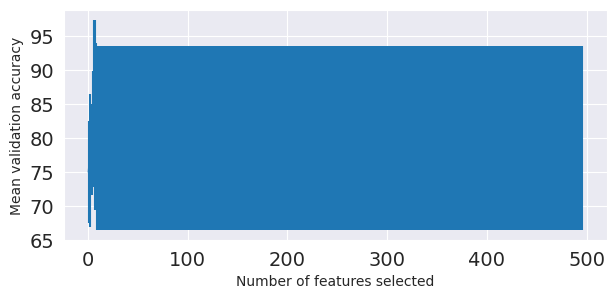

In [12]:
import RFECV_Func
importlib.reload(RFECV_Func)
best_features = RFECV_Func.rfecv_sel(x_train, y_train, healthcode_train, modelxgb, "Fred_emobase")

In [13]:
print(best_features)

Index(['mfcc_sma_3__linregerrA', 'mfcc_sma_3__linregerrQ', 'mfcc_sma_5__range',
       'mfcc_sma_7__amean', 'lspFreq_sma_7__stddev', 'voiceProb_sma_quartile1',
       'mfcc_sma_de_9__linregc1', 'mfcc_sma_de_9__linregerrQ',
       'mfcc_sma_de_11__amean', 'voiceProb_sma_de_quartile1'],
      dtype='object')


In [36]:
best_features =['mfcc_sma_3__linregerrA', 'mfcc_sma_3__linregerrQ', 'mfcc_sma_5__range',
       'mfcc_sma_7__quartile1', 'lspFreq_sma_7__stddev',
       'mfcc_sma_de_9__linregerrQ', 'mfcc_sma_de_11__amean',
       'lspFreq_sma_de_0__linregc1']

# =============================
# Model Training with Selected Features
# =============================

In [ ]:
model_rfe = XGBClassifier(eval_metric='mlogloss')
x_train_rfe = x_train[best_features]
data_test_meta = data_test_s[['age', 'healthcode', 'y', 'age_range', 'gender']]
x_test_rfe = data_test_s[best_features]
data_test_rfe = pd.concat([x_test_rfe, data_test_meta], axis=1)

model_rfe.fit(x_train_rfe, y_train)

# Finetuning

In [15]:
from sklearn.model_selection import GridSearchCV
# Define the parameter grid
param_grid = {
    'n_estimators': range(20, 101, 10),
    'max_depth': range(2, 8, 2)
}
cv2 = GroupShuffleSplit(n_splits=2, test_size=0.2, random_state=0)
# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=model_rfe, param_grid=param_grid, scoring='accuracy', cv=cv2, verbose=1, n_jobs=-1)

# Fit the grid search to the data
grid_search.fit(x_train_rfe, y_train, groups=healthcode_train)

# Print the best parameters and the best score
print(f"Best parameters found: {grid_search.best_params_}")
print(f"Best accuracy found: {grid_search.best_score_:.4f}")

# Use the best model found to make predictions
best_model = grid_search.best_estimator_

Fitting 2 folds for each of 27 candidates, totalling 54 fits
Best parameters found: {'max_depth': 2, 'n_estimators': 20}
Best accuracy found: 0.7500


# =============================
# Model Evaluation
# =============================

# Test scores

In [16]:
import Evaluation
importlib.reload(Evaluation)
Evaluation.evaluate_model(best_model, data_test_rfe)

Accuracy: 0.7200
Precision: 0.8182
Recall: 0.6429
F1-score: 0.7200
ROC AUC: 0.8571
Specificity: 0.8182

Confusion Matrix:
   0  1
0  9  2
1  5  9

Classification Report:
              precision    recall  f1-score   support

           0       0.64      0.82      0.72        11
           1       0.82      0.64      0.72        14

    accuracy                           0.72        25
   macro avg       0.73      0.73      0.72        25
weighted avg       0.74      0.72      0.72        25


# CV scores

In [17]:
import Evaluation
importlib.reload(Evaluation)

Evaluation.cv_scores(x_train_rfe,y_train, healthcode_train, best_model)

accuracy: 0.8056 (+/- 0.0786)
precision: 0.9167 (+/- 0.1179)
recall: 0.6683 (+/- 0.1173)
f1: 0.7677 (+/- 0.1030)
roc_auc: 0.9146 (+/- 0.0620)
specificity: 0.9524 (+/- 0.0673)
